# **Unsupervised Model Tuning and Exploration**
---


Author - Liam Duncan \
File - unsupervised-exploration.ipynb


**Description:**
---
The goal of this notebook is to explore the different clustering models and determine the best model to use on our entire dataset.\

The 3 clustering models that will be looked at are: DBSCAN, Agglomerative Clustering, and KMeans clustering.\
Each clustering method will be tuned before being compared to decide which model will give the best results.\
A PCA analysis is also performed to determine the number of principle components to use in our models.\
Different Z-score thresholds are tested to determine the correct percentage of points to view as noise and therefore remove.\
\
The results from the areas listed above will dictate what final model will be used as our unsupervised clustering algorithm.

**Dataset:** 
---
The dataset used in this study is obtained from the Temple University EEG\
Corpus, which contains EEG recordings collected for psychiatric disorder clas sification. \
The dataset includes both normal and abnormal EEG recordings,\
categorized based on clinical evaluations.\
Source: Lopez, S. (2017). Automated Identification of Abnormal EEGs. 
 Temple University. \
 https://isip.piconepress.com/projects/nedc/html/tuh_eeg/

In [2]:
import os
import mne
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy import stats
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.stats import mode
import seaborn as sns

# READ DATA


In [3]:


# Define common EEG channels
COMMON_CHANNELS = [
    'EEG F7-REF', 'EEG A2-REF', 'EEG C3-REF', 'EEG CZ-REF', 'EEG T3-REF',
    'EEG P3-REF', 'EEG C4-REF', 'EEG PZ-REF', 'EEG T5-REF', 'EEG A1-REF',
    'EEG FP2-REF', 'EEG FP1-REF', 'SUPPR', 'IBI', 'EEG P4-REF', 'EEG FZ-REF',
    'EEG T4-REF', 'EEG O1-REF', 'EEG F8-REF', 'BURSTS', 'EEG O2-REF',
    'EEG T6-REF', 'EEG F3-REF', 'EEG F4-REF'
]

# Fixed length for EEG data after processing
FIXED_LENGTH = 30000  # Reduce this if memory is an issue
TARGET_SAMPLING_RATE = 250  # Reduced for better training efficiency

# Function to find the maximum EEG length in the dataset
def find_max_length(folder_paths):
    """Finds the maximum EEG signal length across all files."""
    max_length = FIXED_LENGTH  # Use a fixed value to prevent memory issues
    print(f"[INFO] Using fixed max length: {max_length} samples per EEG recording")
    return max_length

# Function to load and preprocess EEG data
def load_eeg(file_path, target_sampling_rate=TARGET_SAMPLING_RATE, fixed_length=FIXED_LENGTH):
    """Loads EEG data, selects common channels, resamples, and ensures fixed length."""
    print(f"[INFO] Loading file: {file_path}")

    try:
        raw = mne.io.read_raw_edf(file_path, preload=True)
        original_sfreq = raw.info['sfreq']

        # Resampling for uniform sample rate
        if original_sfreq != target_sampling_rate:
            raw.resample(target_sampling_rate)
            print(f"  - Resampled from {original_sfreq} Hz to {target_sampling_rate} Hz")

        available_channels = raw.ch_names
        selected_indices = [i for i, ch in enumerate(available_channels) if ch in COMMON_CHANNELS]

        if len(selected_indices) < len(COMMON_CHANNELS):
            print(f"[WARNING] {file_path} has only {len(selected_indices)} of {len(COMMON_CHANNELS)} common channels.")

        data = raw.get_data()[selected_indices, :]  # Shape: (channels, time)

        # Debugging prints
        num_samples = data.shape[1]
        print(f"  - EEG Data Shape Before Processing: {data.shape} (Channels, Time)")
        print(f"  - Number of Samples Before Padding: {num_samples}")

        # Ensure fixed length
        if num_samples > fixed_length:
            data = data[:, :fixed_length]  # Truncate long signals
            print(f"  - Truncated to: {fixed_length} samples")
        elif num_samples < fixed_length:
            pad_width = fixed_length - num_samples
            data = np.pad(data, ((0, 0), (0, pad_width)), mode='constant')  # Pad short signals
            print(f"  - Padded to: {fixed_length} samples")

        # Final shape check
        print(f"  - EEG Data Shape After Processing: {data.shape} (Channels, Time)")

        return data

    except Exception as e:
        print(f"[ERROR] Failed to load {file_path}: {e}")
        return None

# EEG Dataset Class for Unsupervised Learning (No Labels)
class EEGDataset:
    def __init__(self, abnormal_folder, normal_folder):
        self.file_paths = []

        for file in os.listdir(abnormal_folder):
            if file.endswith('.edf'):
                self.file_paths.append(os.path.join(abnormal_folder, file))

        for file in os.listdir(normal_folder):
            if file.endswith('.edf'):
                self.file_paths.append(os.path.join(normal_folder, file))

        self.fixed_length = find_max_length([abnormal_folder, normal_folder])

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        eeg_data = load_eeg(self.file_paths[idx], TARGET_SAMPLING_RATE, self.fixed_length)

        if eeg_data is None:
            print(f"[ERROR] Skipping file at index {idx} due to loading failure.")
            return None

        return eeg_data

# Set your paths here
abnormal_folder = r"../abnormal_train_data"
normal_folder = r"../normal_train_data"

print("[INFO] Initializing EEG dataset...")
dataset = EEGDataset(abnormal_folder, normal_folder)

print(f"[INFO] Total EEG Files Loaded: {len(dataset)}")

# Extract EEG data for clustering
all_data = []

for idx in range(len(dataset)):
    eeg_data = dataset[idx]
    if eeg_data is not None:
        all_data.append(eeg_data.flatten())  # Flatten each sample for clustering

# Convert to numpy array
all_data = np.array(all_data)



[INFO] Initializing EEG dataset...
[INFO] Using fixed max length: 15000 samples per EEG recording
[INFO] Total EEG Files Loaded: 500
[INFO] Loading file: /Users/liamduncan/Downloads/CMPT 340/abnormal/aaaaaeqd_s010_t000.edf
Extracting EDF parameters from /Users/liamduncan/Downloads/CMPT 340/abnormal/aaaaaeqd_s010_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 302749  =      0.000 ...  1210.996 secs...
  - Resampled from 250.0 Hz to 128 Hz
  - EEG Data Shape Before Processing: (24, 155008) (Channels, Time)
  - Number of Samples Before Padding: 155008
  - Truncated to: 15000 samples
  - EEG Data Shape After Processing: (24, 15000) (Channels, Time)
[INFO] Loading file: /Users/liamduncan/Downloads/CMPT 340/abnormal/aaaaabhz_s007_t001.edf
Extracting EDF parameters from /Users/liamduncan/Downloads/CMPT 340/abnormal/aaaaabhz_s007_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0

In [4]:
print(all_data.shape)

(500, 360000)


---
---

## PCA ANALYSIS

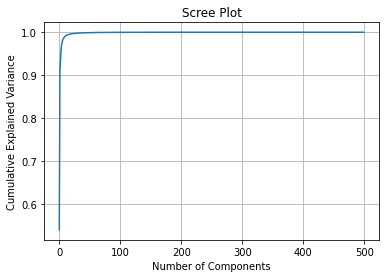

In [5]:


# Fit PCA
pca = PCA().fit(all_data)  # X is your dataset

# Scree Plot
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid()
plt.show()

In [6]:

# Compute cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# Generate x values (component numbers)
num_components = np.arange(1, len(cumulative_variance) + 1)

# Filter points where x is between 0 and 100
filtered_indices = num_components <= 10  # Ensures we only take components up to 100
filtered_x = num_components[filtered_indices]
filtered_y = cumulative_variance[filtered_indices]

# Print the filtered points
print("Variance explained\n"
"----------------------------")
for x, y in zip(filtered_x, filtered_y):
    print(f"Component {x}: {y:.4f}")


Variance explained
----------------------------
Component 1: 0.5405
Component 2: 0.9104
Component 3: 0.9384
Component 4: 0.9619
Component 5: 0.9723
Component 6: 0.9798
Component 7: 0.9833
Component 8: 0.9861
Component 9: 0.9884
Component 10: 0.9901


---
---

## OUTLIER THRESHOLD TESTING

In [7]:


# Standardize training data
scaler2 = StandardScaler()
all_data_scaled_scored = scaler2.fit_transform(all_data)  # Fit scaler on training data


# Define the thresholds to test
thresholds = [20, 21, 22, 23]
best_score = -1
best_threshold = None
best_labels = None

for threshold in thresholds:
    # Compute Z-scores
    z_scores = np.abs(stats.zscore(all_data_scaled_scored))
    
    # Remove outliers based on the current threshold
    all_data_no_outliers = all_data_scaled_scored[(z_scores < threshold).all(axis=1)]

    
    # Apply PCA (you can adjust n_components as needed)
    pca2 = PCA(n_components=2)
    pca_outlier = pca2.fit_transform(all_data_no_outliers)
    
    # Train KMeans on the cleaned training data
    kmeans2 = KMeans(n_clusters=2, random_state=42, init='k-means++')
    outlier_cluster_labels = kmeans2.fit_predict(all_data_no_outliers)
    
    sil_score2 = silhouette_score(pca_outlier, outlier_cluster_labels)
    
    print(threshold, all_data_no_outliers.shape[0], sil_score2,)
    # update the best threshold based on results
    if sil_score2 > best_score:
        best_score = sil_score2
        best_threshold = threshold
        best_labels = outlier_cluster_labels

print(f"Best Z-score threshold: {best_threshold}")
print(f"Best Silhouette Score: {best_score:.4f}")



20 425 0.7187093055010051
21 433 0.7149481158841081
22 464 0.7932174457130938
23 500 0.4824097060751295
Best Z-score threshold: 22
Best Silhouette Score: 0.7932


---
---


## TUNING OF DBSCAN

eps=100, min_samples=5, unique labels: [-1]
eps=100, min_samples=10, unique labels: [-1]
eps=100, min_samples=15, unique labels: [-1]
eps=500, min_samples=5, unique labels: [-1  0]
eps=500, min_samples=10, unique labels: [-1  0]
eps=500, min_samples=15, unique labels: [-1  0]
eps=1000, min_samples=5, unique labels: [0]
eps=1000, min_samples=10, unique labels: [0]
eps=1000, min_samples=15, unique labels: [0]
eps=10000, min_samples=5, unique labels: [0]
eps=10000, min_samples=10, unique labels: [0]
eps=10000, min_samples=15, unique labels: [0]


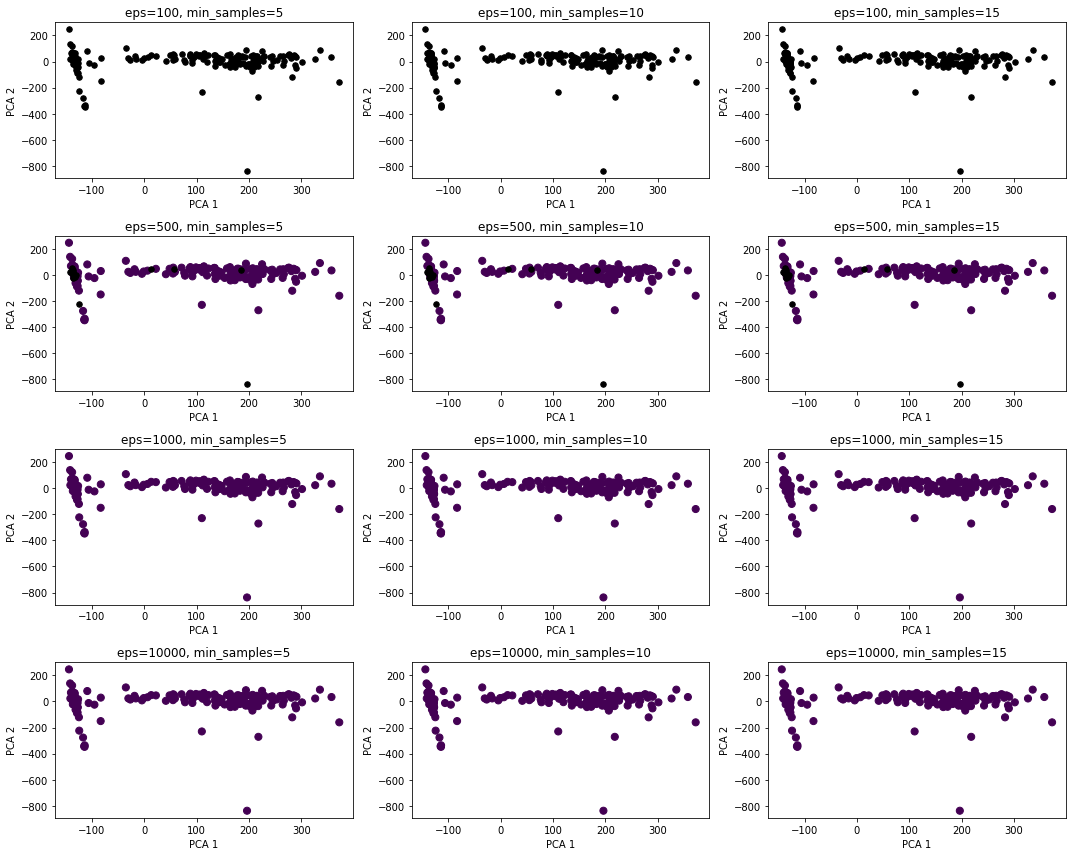

In [17]:


# Perform PCA to reduce the data to 2D for easy visualization
scaler = StandardScaler()
all_data_scaled = scaler.fit_transform(all_data)
z_scores = np.abs(stats.zscore(all_data_scaled))
data_scaled = all_data_scaled[(z_scores < 10).all(axis=1)]
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_scaled)

# Values to iterate over for eps and min_samples
eps_values = [100,500,1000,10000]
min_samples_values = [5, 10, 15]

# Set up the plot
fig, axes = plt.subplots(len(eps_values), len(min_samples_values), figsize=(15, 12))

# Iterate over eps and min_samples combinations
for i, eps in enumerate(eps_values):
    for j, min_samples in enumerate(min_samples_values):
        # Perform DBSCAN
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(data_scaled)

        # Check the unique labels to understand what DBSCAN is doing
        unique_labels = np.unique(dbscan_labels)
        print(f"eps={eps}, min_samples={min_samples}, unique labels: {unique_labels}")

        # Plot the results
        ax = axes[i, j]
        # Plot only the clusters (ignore noise points labeled as -1)
        ax.scatter(data_2d[dbscan_labels != -1, 0], data_2d[dbscan_labels != -1, 1], c=dbscan_labels[dbscan_labels != -1], cmap='viridis', s=50)
        ax.scatter(data_2d[dbscan_labels == -1, 0], data_2d[dbscan_labels == -1, 1], color='black', s=30, label='Noise')
        ax.set_title(f"eps={eps}, min_samples={min_samples}")
        ax.set_xlabel("PCA 1")
        ax.set_ylabel("PCA 2")

plt.tight_layout()
plt.show()


---
---

## TUNING OF AGGLOMERATIVE CLUSTERING

In [9]:
# Z-score transformation and outlier removal
z_scores = np.abs(stats.zscore(all_data_scaled))
data_scaled = all_data_scaled[(z_scores < 10).all(axis=1)]

# Apply PCA (2 components)
pca2 = PCA(n_components=2)
data_pca = pca2.fit_transform(data_scaled)


n_clusters=2, linkage=ward, metric=euclidean, Silhouette Score: 0.15060092968728817
n_clusters=2, linkage=complete, metric=manhattan, Silhouette Score: 0.4668761106340072
n_clusters=2, linkage=average, metric=manhattan, Silhouette Score: 0.4668761106340072
n_clusters=2, linkage=single, metric=manhattan, Silhouette Score: 0.4668761106340072
n_clusters=3, linkage=ward, metric=euclidean, Silhouette Score: 0.15060092968728817
n_clusters=3, linkage=complete, metric=manhattan, Silhouette Score: 0.4668761106340072
n_clusters=3, linkage=average, metric=manhattan, Silhouette Score: 0.4668761106340072
n_clusters=3, linkage=single, metric=manhattan, Silhouette Score: 0.4668761106340072
n_clusters=4, linkage=ward, metric=euclidean, Silhouette Score: 0.15060092968728817
n_clusters=4, linkage=complete, metric=manhattan, Silhouette Score: 0.4668761106340072
n_clusters=4, linkage=average, metric=manhattan, Silhouette Score: 0.4668761106340072
n_clusters=4, linkage=single, metric=manhattan, Silhouette 

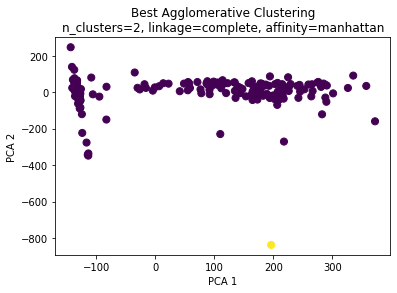

In [14]:


# Define hyperparameter grid
param_grid = {
    'n_clusters': [2, 3, 4, 5],  # Number of clusters
    'linkage': ['ward', 'complete', 'average', 'single']  # Linkage criteria
}

best_score = -1
best_params = None
best_labels = None

# Iterate through all combinations of parameters
for clusters in param_grid['n_clusters']:

    for linkage in param_grid['linkage']:
        # Adjust affinity based on linkage
        if linkage == 'ward':
            affinity = 'euclidean'  # Ward linkage only supports euclidean distance
        else:
            affinity = 'manhattan'  # For other linkage methods, you can try different affinities
        
        agglomerative = AgglomerativeClustering(n_clusters=2, metric=affinity, linkage=linkage)
        agglomerative_labels = agglomerative.fit_predict(data_scaled)
        
        # Calculate silhouette score (higher is better)
        score = silhouette_score(data_scaled, agglomerative_labels)
        
        print(f"n_clusters={clusters}, linkage={linkage}, metric={affinity}, Silhouette Score: {score}")
        
        # Update best model if current model is better
        if score > best_score:
            best_score = score
            best_params = (clusters, linkage, affinity)
            best_labels = agglomerative_labels

# Show best parameters and plot the result
print("\nBest Parameters:", best_params)
print("Best Silhouette Score:", best_score)

# Plot the best result
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=best_labels, cmap='viridis', s=50)
plt.title(f"Best Agglomerative Clustering\nn_clusters={best_params[0]}, linkage={best_params[1]}, affinity={best_params[2]}")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


---
---

## TUNING OF KMEANS


In [11]:
# Z-score transformation and outlier removal
z_scores = np.abs(stats.zscore(all_data_scaled))
data_scaled = all_data_scaled[(z_scores < 10).all(axis=1)]

# Apply PCA (2 components)
pca2 = PCA(n_components=2)
data_pca = pca2.fit_transform(data_scaled)


n_clusters=2, init=k-means++, Silhouette Score: 0.7291085021786888
n_clusters=2, init=random, Silhouette Score: 0.7291085021786888
n_clusters=3, init=k-means++, Silhouette Score: 0.5268501710446355
n_clusters=3, init=random, Silhouette Score: 0.5270573497271843
n_clusters=4, init=k-means++, Silhouette Score: 0.5307028206124831
n_clusters=4, init=random, Silhouette Score: 0.5445046545123914
n_clusters=5, init=k-means++, Silhouette Score: 0.5553181239128242
n_clusters=5, init=random, Silhouette Score: 0.5448908982796891
n_clusters=6, init=k-means++, Silhouette Score: -0.13870718746507346
n_clusters=6, init=random, Silhouette Score: 0.4916862206898675
n_clusters=7, init=k-means++, Silhouette Score: 0.471535726704917
n_clusters=7, init=random, Silhouette Score: -0.2183447967952171
n_clusters=8, init=k-means++, Silhouette Score: -0.24170197116203843
n_clusters=8, init=random, Silhouette Score: 0.22936764267492474

Best Parameters: n_clusters= 2 init= k-means++
Best Silhouette Score: 0.72910

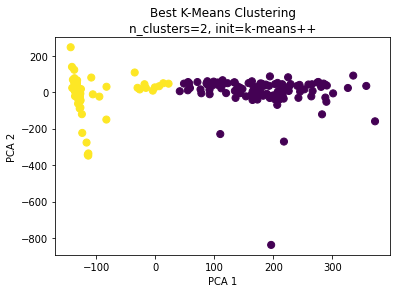

In [16]:

# Define hyperparameter grid
param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8],  # Number of clusters to try
    'init': ['k-means++', 'random']  # Initialization methods
}

best_score = -1
best_params = None
best_labels = None

# Iterate through different cluster sizes and initialization methods
for n_clusters in param_grid['n_clusters']:
    for init_method in param_grid['init']:
        kmeans = KMeans(n_clusters=n_clusters, init=init_method, n_init =100, random_state=42)
        kmeans_labels = kmeans.fit_predict(data_scaled)
        
        # Calculate silhouette score (higher is better)
        score = silhouette_score(data_pca, kmeans_labels)
        
        print(f"n_clusters={n_clusters}, init={init_method}, Silhouette Score: {score}")
        
        # Update best model if current model is better
        if score > best_score:
            best_score = score
            best_params = (n_clusters, init_method)
            best_labels = kmeans_labels

# Show best parameters and plot the result
print("\nBest Parameters: n_clusters=", best_params[0], "init=", best_params[1])
print("Best Silhouette Score:", best_score)

# Plot the best result
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=best_labels, cmap='viridis', s=50)
plt.title(f"Best K-Means Clustering\nn_clusters={best_params[0]}, init={best_params[1]}")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


---
---
---

## MODEL COMPARISON

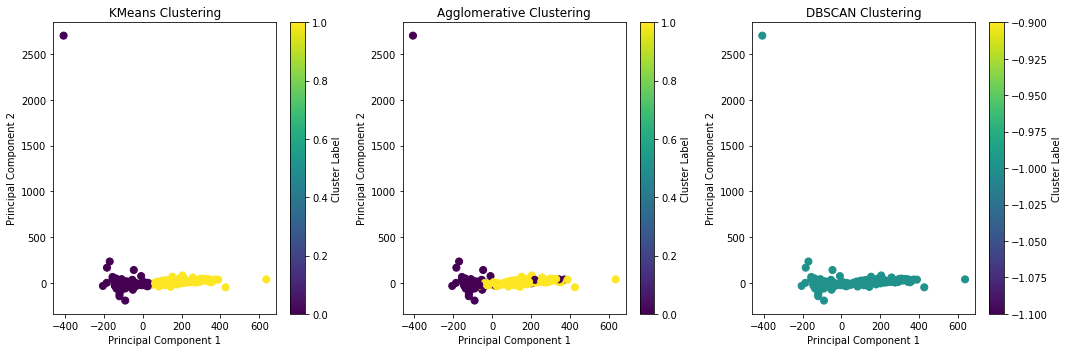

KMeans Silhouette Score: 0.7674248243897149
Agglomerative Clustering Silhouette Score: 0.7089518051979207
DBSCAN Silhouette Score: -1


In [ ]:


# Assume X_train_scaled and X_eval are already defined

# Z-score transformation and outlier removal
z_scores = np.abs(stats.zscore(all_data_scaled_scored))
X_train_no_outliers = all_data_scaled_scored[(z_scores < 22).all(axis=1)]

# Apply PCA (2 components)
pca2 = PCA(n_components=2)
X_train_pca = pca2.fit_transform(X_train_no_outliers)

# --- KMeans ---
kmeans2 = KMeans(n_clusters=2, random_state=47, n_init=100, init='k-means++')
train_cluster_labels_kmeans = kmeans2.fit_predict(X_train_no_outliers)
sil_score_kmeans = silhouette_score(X_train_pca, train_cluster_labels_kmeans)

# --- Agglomerative Clustering ---
agglo = AgglomerativeClustering(n_clusters=2)
train_cluster_labels_agglo = agglo.fit_predict(X_train_no_outliers)
sil_score_agglo = silhouette_score(X_train_pca, train_cluster_labels_agglo)

# --- DBSCAN ---
dbscan = DBSCAN(eps=0.5, min_samples=5)
train_cluster_labels_dbscan = dbscan.fit_predict(X_train_no_outliers)

# Remove outliers for silhouette score calculation (label -1 indicates outliers in DBSCAN)
dbscan_labels_filtered = train_cluster_labels_dbscan[train_cluster_labels_dbscan != -1]
X_train_pca_filtered = X_train_pca[train_cluster_labels_dbscan != -1]

# Only calculate silhouette score if there are more than one cluster
if len(np.unique(dbscan_labels_filtered)) > 1:
    sil_score_dbscan = silhouette_score(X_train_pca_filtered, dbscan_labels_filtered)
else:
    sil_score_dbscan = -1  # No valid clusters, silhouette score can't be computed

# --- Plotting Results ---
plt.figure(figsize=(15, 5))

# KMeans Plot
plt.subplot(1, 3, 1)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_cluster_labels_kmeans, cmap='viridis', s=50)
plt.title("KMeans Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster Label")

# Agglomerative Clustering Plot
plt.subplot(1, 3, 2)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_cluster_labels_agglo, cmap='viridis', s=50)
plt.title("Agglomerative Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster Label")

# DBSCAN Plot
plt.subplot(1, 3, 3)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=train_cluster_labels_dbscan, cmap='viridis', s=50)
plt.title("DBSCAN Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster Label")

plt.tight_layout()
plt.show()

# Print Silhouette Scores
print(f"KMeans Silhouette Score: {sil_score_kmeans}")
print(f"Agglomerative Clustering Silhouette Score: {sil_score_agglo}")
print(f"DBSCAN Silhouette Score: {sil_score_dbscan}")


---
---

## GROUND TRUTH PLOT & ACCURACY

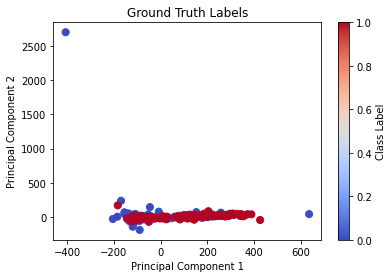

In [ ]:
# Generate ground truth labels
ground_truth_labels = np.zeros(len(X_train_no_outliers))  # Initialize all to class 0
ground_truth_labels[250:] = 1  # Set class 1 for indices 250 and beyond

# --- Ground Truth Plot ---  # Place it next to the KMeans plot
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=ground_truth_labels, cmap='coolwarm', s=50)
plt.title("Ground Truth Labels")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Class Label")

plt.show()

In [ ]:


# Generate ground truth labels
ground_truth_labels = np.zeros(len(X_train_no_outliers))  
ground_truth_labels[250:] = 1  

# KMeans assigns arbitrary labels (0/1), so we need to map them to the ground truth
mapped_labels = np.zeros_like(train_cluster_labels_kmeans)

# Find the most common ground truth label for each cluster
for cluster in np.unique(train_cluster_labels_kmeans):
    mask = train_cluster_labels_kmeans == cluster
    most_common_label = mode(ground_truth_labels[mask], keepdims=True).mode[0]
    mapped_labels[mask] = most_common_label  # Assign mapped labels

# Compute accuracy
correct_assignments = np.sum(mapped_labels == ground_truth_labels)
total_points = len(ground_truth_labels)
accuracy = (correct_assignments / total_points) * 100
error = 100 - accuracy

print(f"Correctly clustered points: {accuracy:.2f}%")
print(f"Incorrectly clustered points: {error:.2f}%")


Correctly clustered points: 70.04%
Incorrectly clustered points: 29.96%
